# Load libraries and global variables

In [ ]:
#import all required libraries for our program
import random
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time as t
import scipy.stats as st
from warnings import filterwarnings
filterwarnings('ignore')

start_time = t.time()

#initialize global dataframes to be used by the functions
global dfTravel
global dfLocations
global dfPopulation
global dfTimeline
global simulationEndTime
global contagiousDurationSum
global challengesAll
global challengesRecover
global challengesDeath
global dfPandemicDuration

# Random Number Generating / Tuning Functions

In [ ]:
def createRecoverHealth(numPeople):
  '''
  Returns a random value according to a triangular distribution for the threshold of if someone will become infected AND eventually recover
  '''
  a = 0.97 #min
  b = 0.99 #max
  c = 0.98 #most likely
  return np.random.triangular(a, c, b, numPeople) # Distribution

In [ ]:
def createDeathHealth(numPeople):
  '''
  Returns a random value according to a triangular distribution for the threshold of if someone will become infected AND eventually die from the disease
  '''
  a = 0.97 #min
  b = 0.999 #max
  c = 0.98 #most likely
  return np.random.triangular(a, c, b, numPeople) # Distribution

In [ ]:
def bonusHealthDecay():
  '''
  Person's bonus health decays over time until it reaches 0 by a random value according to a triangular distribution
  Simulates the person's temporary boosted immune system decaying to baseline
  '''
  a = 0.01 #min
  b = 0.02 #max
  c = 0.015 #most likely
  dfPopulation['bonusHealth'] = dfPopulation['bonusHealth']-np.random.triangular(a, c, b, len(dfPopulation)) # Distribution
  dfPopulation['bonusHealth'] = dfPopulation['bonusHealth'].clip(lower=0)

In [ ]:
def createBonusHealth(numPeople):
  '''
  Returns a random value according to a triangular distribution for amount of bonus health added to a recovering or vaccinated individual
  '''
  a = 0.4 #min
  b = 0.8 #max
  c = 0.6 #most likely
  return np.random.triangular(a, c, b, numPeople) # Distribution

In [ ]:
def createTravel(numPeople):
  '''
  Create a travel timeline for the simulation

  Creates a dataframe of n rows by m columns where
  n = number of people
  m = number of time steps equal to simulationEndTime

  Each row is a geometric distribution, multiplied by a random integer to shuffle the locations, and modulus by the number of locations created
  Each row has it's own probability for the geometric
  '''

  global dfTravel
  global dfLocations
  global simulationEndTime
  global dfPopulation

  numLocations = len(dfLocations)

  # Creates a uniform distribution for each person. Represents the a person's characteristic of more likely to stay home or more likely to travel
  probabilities = np.random.uniform(0.1, 0.8, size=numPeople) # Distribution
  dfPopulation['travel'] = probabilities

  # Creates a travel plan for each person using the probability above. A 1 represents their 1st likely place to go, a 2 represents their 2nd likely place to go, etc.
  data = np.random.geometric(probabilities[:, np.newaxis], size=(numPeople, simulationEndTime+1)) # Distribution
  columns = [f'Time_{i}' for i in range(simulationEndTime+1)]
  df = pd.DataFrame(data, columns=columns)

  # Converts a person's 2nd to nth likely place to go to a random location.
  # Person's 1st likely place is 0 which represents home / can't be infected / isolating
  # Modulus to prevent going over the number of locations
  df = df.apply(lambda row: (row-1)*np.random.randint(1,numLocations)%numLocations, axis=1)
  dfTravel = pd.concat([dfTravel,df], ignore_index=True)

# System Functions

In [ ]:
def initializeSimulation(numPeople, numLocations, maxRepLength, seedRun = False):
  '''
  numPeople = Integer of number of people to start simulation with
  numLocations = Integer of number of locations
  maxRepLength = Max number of days in each simulation
  seedRun = Boolean to set random seed to 42 for repeatability (optional)

  Creates the initial state of the simulation such as time, locations, initial population, timeline, travel and vaccine status.
  Moves people to their starting locations
  Initialize vaccine status
  Sets challenge variables to 0

  Calls:
  initializeDataframes()
  createLocation(numLocations)
  createPerson(numPeople)
  createTravel(numPeople)
  setStartingLocations()
  '''

  # Set seed
  if seedRun == True:
    random.seed(42)
    np.random.seed(42)

  # Time = 0
  global time
  time = 0

  global simulationEndTime
  simulationEndTime = maxRepLength # Tuning

  #Initializes dataframes
  global dfTimeline
  global dfPopulation
  global dfLocations
  global dfTravel

  initializeDataframes()

  # Create initial locations
  createLocation(numLocations)

  # Create initial population
  createPerson(numPeople)

  # Create travel dataframe
  createTravel(numPeople)

  # Set starting locations based on highest probability
  setStartingLocations()

  # Create initial vaccine status
  global vaccineStatus
  vaccineStatus = {'status':'Pre-Development', 'developmentStartTime':-1, 'developmentEndTime':-1, 'supply':0}

  # Create empty list for contagious duration
  global contagiousDurationSum
  contagiousDurationSum = 0

  # Track infection challenges
  global challengesAll
  global challengesRecover
  global challengesDeath
  challengesAll = 0
  challengesRecover = 0
  challengesDeath = 0

In [ ]:
def initializeDataframes():
  '''
  Creates empty dataframes
  '''
  global dfTimeline
  global dfPopulation
  global dfLocations
  global dfTravel

  dfTimeline = pd.DataFrame(columns=['Time','countSick','countSusceptible','countRecovered','countVaccinated','countDead','countLifetimeVaccinated', 'countContagious', 'Growth Rate'])
  dfPopulation = pd.DataFrame()
  dfLocations = pd.DataFrame()
  dfTravel = pd.DataFrame()

In [ ]:
def incrementTime(vaccineDevelopmentIndicator,step=False):
  '''
  step = Boolean to step at 1 time unit or run until ending condition (optional)

  Runs simulation either at 1 time unit or until ending condition endSimulation() is met

  Calls:
  travel()
  exposeBinomial()
  decreaseTimeUntil()
  checkVaccineDevelopment()
  vaccinatePerson()
  dayResult()
  endSimulation(step)

  '''
  repeat = True
  while repeat == True:
    global time
    time = time + 1
    print(f'Time: '+str(time))

    travel()
    exposeBinomial()
    decreaseTimeUntil()

    if vaccineDevelopmentIndicator==True:
      checkVaccineDevelopment()
      vaccinatePerson()

    dayResult()

    if repeat == True:
      repeat = not endSimulation(step)

In [ ]:
def endSimulation(step):
  '''
  step = Boolean if should only run 1 time or loop

  Returns a boolean

  Flag to mark end of simulation based off (variable endTime) of time or if everyone is healthy (disease erradicted) or everyone is dead
  step is used to run just 1 time unit of the simulation instead of all at once

  Calls:
  countAlive()
  countSick()
  '''

  endTime = simulationEndTime
  if time >= endTime:
    return True
  if countAlive() == 0 or countSick() == 0 :
    return True
  if step == True:
    return True
  else:
    return False

In [ ]:
def runSimulation(numPeople, numLocations, maxRepLength, vaccineDevelopmentIndicator, seedRun=False, numRepetitions=1):
  '''
  Initializes replication results, then for the required amount of replications, initialize each replication's result functions and
  its initial five sick individuals. Next, it increments the time of the simulation until the end, then logs the results of each replication
  and generates graphs

  Calls:
  initializeReplicationResults()
  initializeSimulation()
  infection()
  countSick()
  countSusceptible()
  countRecovered()
  countVaccinated()
  countDead()
  countLifetimeVaccinated()
  countContagious()
  incrementTime()
  replicationResults()
  getPeakSick()
  createRepStackedGraph()
  createGrowthRateGraph()
  createPandemicDurationGraph()



  '''

  initializeReplicationResults()

  for simulationRep in range(numRepetitions):
    print(f'Simulation run: {simulationRep}')

    initializeSimulation(numPeople,numLocations, maxRepLength, seedRun)

    global challengesRecover
    global challengesDeath
    global challengesAll
    global contagiousDurationSum

    # Patient Zero (5 people)
    infection(0,0, False)
    infection(1,1, False)
    infection(2,2, False)
    infection(3,3, False)
    infection(4,4, False)

    # Set to 5 for the Patient Zeros
    challengesAll = 5
    challengesRecover = 5

    # Day 0 information
    dfTimeline.loc[len(dfTimeline)] = [time, countSick(), countSusceptible(), countRecovered(), countVaccinated(), countDead(), countLifetimeVaccinated(), countContagious(), 0]

    incrementTime(vaccineDevelopmentIndicator,step=False)

    dfTimeline['dailySick'] = dfTimeline['countSick'].diff()
    dfTimeline['dailyDead'] = dfTimeline['countDead'].diff()

    replicationResults(simulationRep, time, getPeakSick(), countDead(), challengesRecover, challengesDeath, challengesAll, vaccineStatus['developmentStartTime'], contagiousDurationSum, dfTimeline['countSick'].sum())

  # Create graphs for the last replication
  createRepStackedGraph()
  createGrowthRateGraph()
  createPandemicDurationGraph()


# Population Functions

In [ ]:
def createPerson(numPeople):
  '''
  numPeople = Number of people to create and add to population dataframe

  A person has several attributes
  deathHealth must be greater than recoverHealth

  Calls:
  createRecoverHealth(numPeople)
  createDeathHealth(numPeople)
  '''

  global dfPopulation

  df = pd.DataFrame()
  df['personId'] = np.arange(len(dfPopulation), len(dfPopulation)+numPeople)
  df['status'] = 'Susceptible'
  df['contagious'] = False
  df['timeUntilContagious'] = 0
  df['timeUntilNoncontagious'] = 0
  df['timeUntilRecovered'] = 0
  df['willDieFromInfection'] = False
  df['bonusHealth'] = 0
  df['vaccinated'] = 0
  df['recoverHealth'] = createRecoverHealth(numPeople)
  df['deathHealth'] = createDeathHealth(numPeople)
  df['currentLocation'] = -1
  df['timeOfBirth'] = time
  df['timeOfDeath'] = -1

  dfPopulation = pd.concat([dfPopulation, df], ignore_index=True)

# Population Count Functions

In [ ]:
def countAlive():
  '''
  Returns the number of people alive

  Calls:
  countDead()
  '''

  return len(dfPopulation)-countDead()

In [ ]:
def countDead():
  '''
  Returns the number of people dead
  '''
  return len(dfPopulation[dfPopulation['status']=='Dead'])

In [ ]:
def countSick():
  '''
  Returns the number of people sick / infected
  '''

  return len(dfPopulation.query("status == 'Infected - Pre-contagious' or status == 'Infected - Contagious' or status == 'Infected - Post-contagious'"))

In [ ]:
def countVaccinated():
  '''
  Returns the number of people who are currently vaccinated
  '''

  return len(dfPopulation[dfPopulation['status']=='Vaccinated'])

In [ ]:
def countLifetimeVaccinated():
  '''
  Returns the number of people who have been vaccinated at least once
  '''

  return len(dfPopulation[dfPopulation['vaccinated']>0])

In [ ]:
def countSusceptible():
  '''
  Returns the number of people who are currently susceptible
  '''

  return len(dfPopulation[dfPopulation['status']=='Susceptible'])

In [ ]:
def countRecovered():
  '''
  Returns the number of people who are currently recovered
  '''

  return len(dfPopulation[dfPopulation['status']=='Recovered'])

In [ ]:
def getPeakSick():
  '''
  Returns the number where the most people were sick
  '''

  return dfTimeline['countSick'].max()

In [ ]:
def countContagious():
  '''
  Returns the number of people who are currently contagious
  '''

  return dfPopulation['contagious'].sum()

In [ ]:
def getMaxDailySick():
  '''
  Returns the maximum number of people who got sick in one day
  '''

  return dfTimeline['dailySick'].max()

In [ ]:
def getMaxDailyDead():
  '''
  Returns the maximum number of people who died in one day
  '''

  return dfTimeline['dailyDead'].max()

# Location Functions

In [ ]:
def createLocation(numLocations):
  '''
  numLocations = Number of locations to be created
  Creates a location with some attributes and adds to the locations dataframe
  '''

  global dfLocations

  df = pd.DataFrame()
  df['locationId'] = np.arange(len(dfLocations), len(dfLocations)+numLocations)
  dfLocations = pd.concat([dfLocations,df], ignore_index=True)

In [ ]:
def travel():
  '''
  Moves everyone to the corresponding time in the travel dataframe
  '''

  dfPopulation['currentLocation']=dfTravel.iloc[:,time]

In [ ]:
def setStartingLocations():
  '''
  Moves everyone to their first location in the travel dataframe
  '''

  dfPopulation['currentLocation']=dfTravel.iloc[:,0]

# Disease Functions

In [ ]:
def decreaseTimeUntil():
  '''
  For each person in the population, decrease the various timeUntil attributes by 1 to simulate the recovery process
  Each timeUntil cannot go below 0
  Checks if the person's status should change states

  Calls:
  bonusHealthDecay()
  changeStatus()
  '''
  global dfPopulation
  dfPopulation['timeUntilContagious'] = dfPopulation['timeUntilContagious']-1
  dfPopulation['timeUntilNoncontagious'] = dfPopulation['timeUntilNoncontagious']-1
  dfPopulation['timeUntilRecovered'] = dfPopulation['timeUntilRecovered']-1

  dfPopulation['timeUntilContagious'] = dfPopulation['timeUntilContagious'].clip(lower=0)
  dfPopulation['timeUntilNoncontagious'] = dfPopulation['timeUntilNoncontagious'].clip(lower=0)
  dfPopulation['timeUntilRecovered'] = dfPopulation['timeUntilRecovered'].clip(lower=0)

  bonusHealthDecay()

  changeStatus() # Change status of person and decays bonus health if applicable

In [ ]:
def changeStatus():
  '''
  Makes sure that a person's attributes are valid for their current status
  Checks for any transitions in their status based on the person's attributes such as their timeUntil

  Calls:
  bonusHealth()
  bonusHealthDecay()
  '''

  # State Changes and Checks

  # Check Susceptible status
  dfSusceptible = dfPopulation[dfPopulation['status']=='Susceptible']
  assert (dfSusceptible['contagious'] == False).all()
  assert (dfSusceptible['timeUntilContagious'] == 0).all()
  assert (dfSusceptible['timeUntilNoncontagious'] == 0).all()
  assert (dfSusceptible['timeUntilRecovered'] == 0).all()
  assert (dfSusceptible['bonusHealth'] == 0).all()

  # Check Dead status
  dfDead = dfPopulation[dfPopulation['status']=='Dead']
  assert (dfDead['contagious'] == False).all()

  # Check Infected - Pre-contagious status
  dfPrecontagious = dfPopulation[dfPopulation['status']=='Infected - Pre-contagious']
  assert (dfPrecontagious['contagious'] == False).all()
  assert (dfPrecontagious['timeUntilNoncontagious'] > 0).all()
  assert (dfPrecontagious['timeUntilRecovered'] > 0).all()
  # If timeUntilContagious == 0 -> Contagious. Change status and contagious to true
  subset = dfPopulation.query("status == 'Infected - Pre-contagious' and timeUntilContagious == 0")
  subset['status'] = 'Infected - Contagious'
  subset['contagious'] = True
  dfPopulation.loc[subset.index] = subset

  # Check Infected - Contagious status
  dfContagious = dfPopulation[dfPopulation['status']=='Infected - Contagious']
  assert (dfContagious['contagious'] == True).all()
  assert (dfContagious['timeUntilContagious'] == 0).all()
  assert (dfContagious['timeUntilRecovered'] > 0).all()
  # If timeUntilNoncontagious == 0 -> Post-contagious or die. Change status and contagious to false
  subset = dfPopulation.query("status == 'Infected - Contagious' and timeUntilNoncontagious == 0 and willDieFromInfection	== False")
  subset['status'] = 'Infected - Post-contagious'
  subset['contagious'] = False
  dfPopulation.loc[subset.index] = subset
  # Death case
  subset = dfPopulation.query("status == 'Infected - Contagious' and timeUntilNoncontagious == 0 and willDieFromInfection	== True")
  subset['status'] = 'Dead'
  subset['contagious'] = False
  subset['timeOfDeath'] = time
  dfPopulation.loc[subset.index] = subset

  # Check Infected - Post-contagious status
  dfPostcontagious = dfPopulation[dfPopulation['status']=='Infected - Post-contagious']
  assert (dfPostcontagious['contagious'] == False).all()
  assert (dfPostcontagious['timeUntilContagious'] == 0).all()
  assert (dfPostcontagious['timeUntilNoncontagious'] == 0).all()
  # If timeUntilRecovered == 0 -> Recovered. Change status and add bonus health
  subset = dfPopulation.query("status == 'Infected - Post-contagious' and timeUntilRecovered == 0")
  subset['status'] = 'Recovered'
  subset['bonusHealth'] = createBonusHealth(len(subset)) # Distribution
  dfPopulation.loc[subset.index] = subset

  # Check Recovered status
  dfRecovered = dfPopulation[dfPopulation['status']=='Recovered']
  assert (dfRecovered['contagious'] == False).all()
  assert (dfRecovered['timeUntilContagious'] == 0).all()
  assert (dfRecovered['timeUntilNoncontagious'] == 0).all()
  assert (dfRecovered['timeUntilRecovered'] == 0).all()
  # If bonusHealth <= 0 -> Susceptible. Change status
  subset = dfPopulation.query("status == 'Recovered' and bonusHealth <= 0")
  subset['status'] = 'Susceptible'
  dfPopulation.loc[subset.index] = subset

  # Check Vaccinated status
  dfVaccinated = dfPopulation[dfPopulation['status']=='Vaccinated']
  assert (dfVaccinated['contagious'] == False).all()
  assert (dfVaccinated['timeUntilContagious'] == 0).all()
  assert (dfVaccinated['timeUntilNoncontagious'] == 0).all()
  assert (dfVaccinated['timeUntilRecovered'] == 0).all()
  # If bonusHealth <= 0 -> Susceptible. Change status
  subset = dfPopulation.query("status == 'Vaccinated' and bonusHealth <= 0")
  subset['status'] = 'Susceptible'
  dfPopulation.loc[subset.index] = subset

In [ ]:
def exposeBinomial():
  '''
  Exposes people who can be infected (defense) to people who are infected (offense) and infects them according to a binomial distribution,
  to obtain whether the individuals will be infected or not and whether they will recover or die.

  '''
  global dfPopulation

  # Reset categories for everyone
  dfPopulation['defenseCategory'] = 0
  dfPopulation['offenseCategory'] = 0

  # Change categories for certain statuses
  dfPopulation.loc[dfPopulation['status']=='Susceptible', 'defenseCategory'] = 1
  dfPopulation.loc[dfPopulation['status']=='Recovered', 'defenseCategory'] = 1
  dfPopulation.loc[dfPopulation['status']=='Vaccinated', 'defenseCategory'] = 1
  dfPopulation.loc[dfPopulation['status']=='Infected - Contagious', 'offenseCategory'] = 1

  # If at home / location 0, isolating and not to be considered
  dfPopulation.loc[dfPopulation['currentLocation']==0, 'offenseCategory'] = 0
  dfPopulation.loc[dfPopulation['currentLocation']==0, 'defenseCategory'] = 0

  # Group by location
  dfCount = dfPopulation[['currentLocation','defenseCategory','offenseCategory']].groupby('currentLocation', as_index=False).sum()
  dfCount.rename(columns={'offenseCategory':'offenseCount','defenseCategory':'defenseCount'}, inplace=True)

  # Drop columns if necessary due to previous iteration and merge
  if 'defenseCount' in list(dfPopulation.columns):
    dfPopulation.drop(columns=['defenseCount', 'offenseCount'], inplace=True)
  dfPopulation = dfPopulation.merge(dfCount, on='currentLocation', how='left')

  # Figures out how many infected people a person will interact with using a triangular distribtion
  dfPopulation['numInteractions'] = dfPopulation['offenseCount'].apply(lambda x: int(np.random.triangular(left=0, mode=min(20, math.ceil(x/2)), right=min(50, x+1)))) #*tuning
  dfPopulation['numInteractions'] = dfPopulation['numInteractions']*dfPopulation['defenseCategory']

  # Generates a binomial distribution using the number of interactions as the number of bernoulli trials and 1-(recoverHealth+bonusHealth) as the probability of infection
  # If a person is infected, boolRecover is 1
  dfPopulation['infectionsRecover'] = dfPopulation.apply(lambda x: (np.random.binomial(x['numInteractions'], 1-min(x['recoverHealth']+x['bonusHealth'],1))), axis=1) #bonus health considered when checking binomial odds
  dfPopulation['boolRecover'] = dfPopulation['infectionsRecover'].clip(lower=0,upper=1)

  # Calculate the number challenges for each person. Assuming can only be infected once
  dfPopulation['challenges'] = dfPopulation['numInteractions'] -(dfPopulation['infectionsRecover'].clip(lower=1))+1

  # If a person is infected, checks if they will die
  dfPopulation['boolDeath'] = dfPopulation.apply(lambda x: (np.random.binomial(x['numInteractions'], 1-x['deathHealth']))*x['boolRecover'], axis=1).clip(lower=0,upper=1) #roll death only for confirmed infections

  # interaction = 0 -> Nothing happens to person
  # interaction = 1 -> Person becomes infected and will recover
  # interaction = 2 -> Person becomes infected and will die
  dfPopulation['interactions'] = (dfPopulation['boolRecover']+dfPopulation['boolDeath']).clip(lower=0, upper=2)

  # Change information for an infected person
  dfPopulation.loc[(dfPopulation['interactions']>0) & (dfPopulation['defenseCategory']==1), 'status'] = 'Infected - Pre-contagious'
  dfPopulation.loc[(dfPopulation['interactions']==2) & (dfPopulation['defenseCategory']==1), 'willDieFromInfection'] = True
  dfPopulation.loc[(dfPopulation['interactions']>0) & (dfPopulation['defenseCategory']==1), 'timeUntilContagious'] = np.clip(np.random.normal(3,1, size=len(dfPopulation.loc[(dfPopulation['interactions']>0) & (dfPopulation['defenseCategory']==1)])).astype(int), a_min=1, a_max=None)

  # Generates the number of days a person will be contagious
  contagiousDays = np.clip(np.random.normal(11,1, size=len(dfPopulation.loc[(dfPopulation['interactions']>0) & (dfPopulation['defenseCategory']==1)])).astype(int), a_min=1, a_max=None)

  dfPopulation.loc[(dfPopulation['interactions']>0) & (dfPopulation['defenseCategory']==1), 'timeUntilNoncontagious'] = dfPopulation.loc[(dfPopulation['interactions']>0) & (dfPopulation['defenseCategory']==1), 'timeUntilContagious']+contagiousDays
  dfPopulation.loc[(dfPopulation['interactions']>0) & (dfPopulation['defenseCategory']==1), 'timeUntilRecovered'] = dfPopulation.loc[(dfPopulation['interactions']>0) & (dfPopulation['defenseCategory']==1), 'timeUntilNoncontagious']+np.clip(np.random.normal(6,2, size=len(dfPopulation.loc[(dfPopulation['interactions']>0) & (dfPopulation['defenseCategory']==1)])).astype(int), a_min=1, a_max=None)

  # Calculate challenges
  global challengesAll
  global challengesRecover
  global challengesDeath
  global contagiousDurationSum

  challengesAll = challengesAll+dfPopulation['challenges'].sum()
  challengesRecover = challengesRecover+len(dfPopulation.loc[(dfPopulation['interactions']==1) & (dfPopulation['defenseCategory']==1)])
  challengesDeath = challengesDeath+len(dfPopulation.loc[(dfPopulation['interactions']==2) & (dfPopulation['defenseCategory']==1)])
  contagiousDurationSum = contagiousDurationSum+contagiousDays.sum()

In [ ]:
def infection(currentInfectedId, newInfectedId, willDie=False):
  '''
  currentInfectedId = Person who is currently infected
  newInfectedId = Person who was exposed and is getting infected
  willDie = Boolean if person will die from the disease or not at the end the "recovery" process when timeUntilRecovered = 0

  Records the infection event in both currentInfectedId and newInfectedId for contact tracing
  Sets the newInfectedId to Infected and if they will die from the disease
  Sets the recovery timeline for the newInfectedId

  Currently only used for the Patient Zeros
  '''

  dfPopulation.at[newInfectedId, 'status'] = 'Infected - Pre-contagious'
  dfPopulation.at[newInfectedId, 'willDieFromInfection'] = willDie
  dfPopulation.at[newInfectedId, 'timeUntilContagious'] = max(1, round(random.normalvariate(mu=3, sigma=1))) # Assume it takes ~3 days to be contagious after being infected. Incubation period before symptoms show. # Distribution
  contagiousDays = max(1,round(random.normalvariate(mu=11, sigma=1))) # Distribution
  dfPopulation.at[newInfectedId, 'timeUntilNoncontagious'] = dfPopulation.at[newInfectedId, 'timeUntilContagious']+ contagiousDays # This is to ensure we are above time until contagious, and assumes we are contagious for about 4 days (2 before symptoms, 1 after symptoms) # Distribution
  dfPopulation.at[newInfectedId, 'timeUntilRecovered'] = dfPopulation.at[newInfectedId, 'timeUntilNoncontagious']+max(1,round(random.normalvariate(mu=6, sigma=2))) # Takes about 1 week from symptoms to recover     # Distribution

  global contagiousDurationSum
  contagiousDurationSum = contagiousDurationSum+contagiousDays


# Vaccine Functions

In [ ]:
def vaccinatePerson(): #vaccination function
  '''
  Simulates a person receiving a vaccination assuming there vaccines available
  Person receives temporary boosted immune system

  Calls:
  createBonusHealth(numPeople)
  '''

  df = dfPopulation.query("status == 'Susceptible'")

  numVaccinate = min(len(df),vaccineStatus['supply'])
  df = df.sample(n=numVaccinate)
  df['status'] = 'Vaccinated'
  df['vaccinated'] = df['vaccinated']+1
  df['bonusHealth'] = createBonusHealth(len(df))
  dfPopulation.iloc[df.index] = df
  vaccineStatus['supply'] = vaccineStatus['supply']-numVaccinate

  assert vaccineStatus['supply']>=0

In [ ]:
def checkVaccineDevelopment():
  '''
  Simulates the timeline of vaccinate development and distribution

  Calls:
  startVaccineDevelopment()
  vaccineSupply()
  '''
  global vaccineStartDay

  if vaccineStatus['status']=='Pre-Development' and countSick()/countAlive()>=0.05: # Tuning
    startVaccineDevelopment()
    vaccineStartDay=time

  elif vaccineStatus['status']=='Development - In Progress' and time >= vaccineStatus['developmentEndTime']:
    vaccineStatus['status'] = 'Development - Completed'

  elif vaccineStatus['status']=='Development - Completed':
    vaccineStatus['status'] = 'Distribution'

  elif vaccineStatus['status']=='Distribution': #so that supply keeps increasing when distribution
    vaccineStatus['supply'] = vaccineSupply()
    vaccineStatus['status'] = 'Distribution'

In [ ]:
def vaccineSupply():
  '''
  Creates a supply of vaccines
  Follows a distributions
  Returns the number of vaccines created on current day
  '''

  vaccineDailySupply = min(int(len(dfPopulation)*.01*math.exp(0.01*(time-vaccineStatus['developmentEndTime']))),int(len(dfPopulation)*.02)) # rounding for vaccine amounts #distribution* vary min based on expected bonus health duration # Distribution
  return vaccineDailySupply

In [ ]:
def startVaccineDevelopment():
  '''
  Starts the development of a vaccine and duration that development will take
  '''

  vaccineStatus['status'] = 'Development - In Progress'
  vaccineStatus['developmentStartTime'] = time
  vaccineStatus['developmentEndTime'] = time+round(random.normalvariate(mu=45, sigma=5)) # Distribution

# Result Functions

In [ ]:
def dayResult():
  '''
  Captures the results of each time step

  Calls:
  countSick()
  countSusceptible()
  countRecovered()
  countVaccinated()
  countDead()
  countLifetimeVaccinated()
  countContagious()
  '''
  global dfTimeline
  global dfPopulation
  global challengesRecover
  global challengesDeath
  global challengesAll
  global contagiousDurationSum

  # Calculate the day's growth rate compared to previous day
  growthRate = countSick()/dfTimeline.loc[len(dfTimeline)-1, 'countSick']

  # Records daily numbers
  dfTimeline.loc[len(dfTimeline)] = [time, countSick(), countSusceptible(), countRecovered(), countVaccinated(), countDead(), countLifetimeVaccinated(), countContagious(), growthRate]


In [ ]:
def createRepStackedGraph():
  '''
  Creates stacked timeline graph for a sample replication, showing the variations of the different population statuses
  '''
  #Stackplot creates stacked graph to track population over time
  x = dfTimeline['Time']
  sick = dfTimeline['countSick']
  susceptible = dfTimeline['countSusceptible']
  recovered = dfTimeline['countRecovered']
  vaccinated = dfTimeline['countVaccinated']
  dead = dfTimeline['countDead']
  plt.figure(1)
  plt.stackplot(x, sick, susceptible, recovered, vaccinated, dead, labels = ['# Sick', '# Susceptible', '# Recovered', '# Vaccinated', '# Dead'])
  plt.legend(loc=(1.01,0.5), ncol = 1)
  plt.title('Population statistics')
  plt.xlabel('Day')
  plt.ylabel('Population')
  plt.show

In [ ]:
def createGrowthRateGraph():
  '''
  Creates a line graph for the disease growth rate for a sample replication
  '''
  x = dfTimeline['Time'][1:]
  y = dfTimeline['Growth Rate'][1:]
  plt.figure(7)
  plt.plot(x,y)
  plt.xlabel('Time')
  plt.ylabel('Growth Rate')
  plt.title('Growth Rate over Time')
  plt.grid(True)
  plt.show()

In [ ]:
def createPandemicDurationGraph():
  '''
  Creates graphs to display pandemic durations, peak infections, total deaths, and peak growth rate
  Creates a histogram of pandemic duration, peak infection, total deaths, and peak growth rate across all replications
  '''

  plt.figure(2)
  plt.hist(dfPandemicDuration['Pandemic Duration'])
  plt.title('Histogram of Pandemic Durations')
  plt.xlabel('Pandemic Duration')
  plt.ylabel('Iteration count')
  print('\n')
  plt.figure(3)
  plt.hist(dfPandemicDuration['Peak Infection'])
  plt.title('Histogram of Peak Infected Population')
  plt.xlabel('Infection Peak')
  plt.ylabel('Iteration count')
  print('\n')
  plt.figure(4)
  plt.hist(dfPandemicDuration['Total Deaths'])
  plt.title('Histogram of Total Deaths')
  plt.xlabel('Total Deaths')
  plt.ylabel('Iteration count')
  print('\n')
  plt.figure(5)
  plt.hist(dfPandemicDuration['Peak Growth Rate'])
  plt.title('Histogram of Peak Growth Rate')
  plt.xlabel('Peak Growth Rate Value')
  plt.ylabel('Iteration count')
  print('\n')

In [ ]:
def initializeReplicationResults():
  '''
  Initializes dataframe for dfPandemicDuration to store information across multiple replications
  '''
  global dfPandemicDuration
  dfPandemicDuration = pd.DataFrame(columns = ['Iteration', 'Pandemic Duration', 'Peak Infection', 'Total Deaths', 'Total Infection Ratio', 'Vaccine Start Day', 'Average Contagious Duration', 'Average Sick Population', 'Max Daily Infected', 'Max Daily Dead', 'Avg # of Contacts Per Infected Person', 'Transmission Rate', 'Peak Growth Rate'])

In [ ]:
def mean_var_interval(series, alpha = 0.95):
  '''
  Gets the mean, variance, and confidence interval
  '''
  mu = np.mean(series)
  sigSq = st.sem(series)
  sVar = (sigSq**2)*len(series)
  interval = st.t.interval(alpha, df=len(series)-1, loc=mu, scale=sigSq)
  return mu, sigSq, interval, alpha, sVar

In [ ]:
def replicationResults(iter, finishTime, peakInfection, totalDeaths, challengesRecover, challengesDeath, challengesAll, startVaccine, contagiousDurationSum, sickPopulationSum):
  '''
  Records the replication results to dfPandemicDuration

  Calls:
  getMaxDailySick()
  getMaxDailyDead()
  '''

  global dfPandemicDuration
  global dfTimeline

  infectionRatio = 0
  if challengesAll != 0:
    infectionRatio = (challengesRecover+challengesDeath)/challengesAll

  averageContagiousDuration = 0
  if (challengesRecover+challengesDeath) != 0:
    averageContagiousDuration = contagiousDurationSum/(challengesRecover+challengesDeath)

  averageSickPopulation = int(sickPopulationSum/finishTime)

  maxDailySick = getMaxDailySick()
  maxDailyDead = getMaxDailyDead()
  # Average number of contacts that a sick person has
  avgContacts = challengesAll / dfTimeline['countSick'].sum()
  transmissionRate = infectionRatio * avgContacts
  r0 = transmissionRate * averageContagiousDuration

  growthRate = dfTimeline['Growth Rate'].max()

  dfPandemicDuration.loc[len(dfPandemicDuration)] = [iter, finishTime, peakInfection, totalDeaths, infectionRatio, startVaccine, averageContagiousDuration, averageSickPopulation, maxDailySick, maxDailyDead, avgContacts, transmissionRate, growthRate]

# Run Simulation

Simulation run: 0


,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9,...,Time_11,Time_12,Time_13,Time_14,Time_15,Time_16,Time_17,Time_18,Time_19,Time_20
0,0,20,0,10,10,20,0,10,10,10,...,10,0,0,0,20,0,10,10,0,20
1,25,0,15,0,25,0,0,0,20,25,...,0,0,25,0,0,0,0,20,0,0
2,0,4,22,11,3,16,11,11,12,28,...,0,14,22,23,25,17,2,11,22,22
3,18,6,9,9,0,0,6,3,0,0,...,0,3,0,3,6,0,3,3,0,0
4,0,5,20,20,25,25,20,25,5,20,...,0,0,20,10,25,20,20,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,14,28,28,14,0,8,0,14,28,24,...,0,28,0,0,2,8,12,26,6,26
1996,8,0,4,0,0,4,0,0,0,8,...,0,8,8,16,4,24,16,0,0,12
1997,0,0,10,5,0,5,10,0,0,10,...,0,0,5,0,0,0,0,0,0,0
1998,6,21,3,0,21,0,0,12,21,0,...,21,15,0,0,12,3,3,0,21,21


Time: 1
Time: 2
Time: 3
Time: 4
Time: 5
Time: 6
Time: 7
Time: 8
Time: 9
Time: 10
Time: 11
Time: 12
Time: 13
Time: 14
Time: 15
Time: 16
Time: 17
Time: 18
Time: 19
Time: 20
Simulation run: 1


,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9,...,Time_11,Time_12,Time_13,Time_14,Time_15,Time_16,Time_17,Time_18,Time_19,Time_20
0,27,27,0,0,0,0,0,0,0,0,...,24,0,0,0,18,27,0,27,0,0
1,15,0,15,0,0,0,0,15,0,0,...,0,15,15,0,15,15,15,0,0,15
2,21,12,12,24,12,21,0,21,24,0,...,6,0,12,18,3,21,0,21,12,18
3,8,0,0,0,0,8,0,0,8,8,...,0,0,8,0,0,8,0,16,0,0
4,0,10,10,0,0,20,10,0,0,20,...,0,0,0,10,0,20,0,20,20,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,12,27,0,24,12,0,12,21,21,...,0,12,12,24,24,0,21,21,24,21
1996,24,18,0,24,0,24,6,18,0,12,...,0,24,24,0,24,0,0,24,24,24
1997,0,0,0,2,10,0,2,0,2,0,...,2,0,2,6,2,8,0,0,0,0
1998,18,0,18,0,24,24,0,18,0,0,...,24,24,18,24,0,0,18,0,24,0


Time: 1
Time: 2
Time: 3
Time: 4
Time: 5
Time: 6
Time: 7
Time: 8
Time: 9
Time: 10
Time: 11
Time: 12
Time: 13
Time: 14
Time: 15
Time: 16
Time: 17
Time: 18
Time: 19
Time: 20


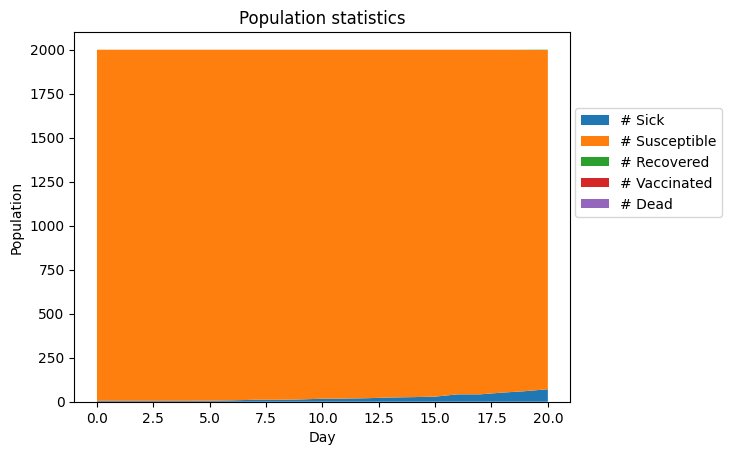

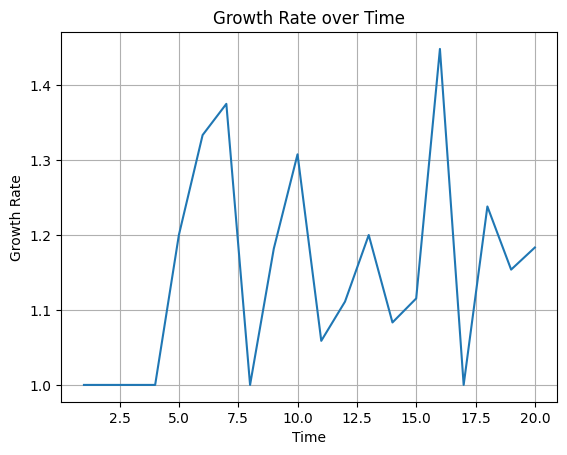

,Iteration,Pandemic Duration,Peak Infection,Total Deaths,Total Infection Ratio,Vaccine Start Day,Average Contagious Duration,Average Sick Population,Max Daily Infected,Max Daily Dead,Avg # of Contacts Per Infected Person,Transmission Rate,Peak Growth Rate
0,0.0,20.0,120.0,0.0,0.018605,-1.0,10.669355,41.0,17.0,0.0,7.982036,0.148503,1.461538
1,1.0,20.0,71.0,0.0,0.023864,-1.0,10.616438,23.0,13.0,0.0,6.440000,0.153684,1.448276


The sample mean of the R0 is:  1.45
The sample variance of the R0 is:  0.01
The 0.95 confidence interval is (1.370648509705358, 1.539165813902069)
The sample mean of the Pandemic Duration is:  20.0
The sample variance of the Pandemic Duration is:  0.0
The 0.95 confidence interval is (nan, nan)
The sample mean of the Pandemic Duration is:  95.5
The sample variance of the Pandemic Duration is:  24.5
The 0.95 confidence interval is (-215.80201604258633, 406.80201604258633)
The sample mean of the Pandemic Duration is:  0.0
The sample variance of the Pandemic Duration is:  0.0
The 0.95 confidence interval is (nan, nan)


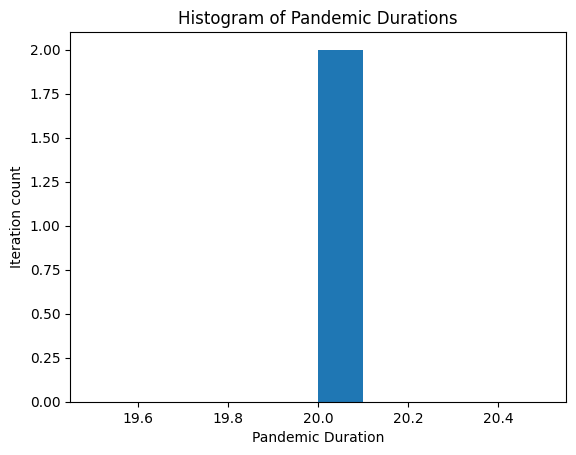

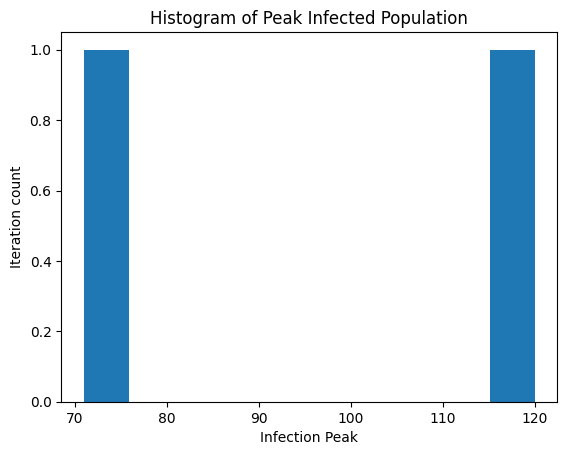

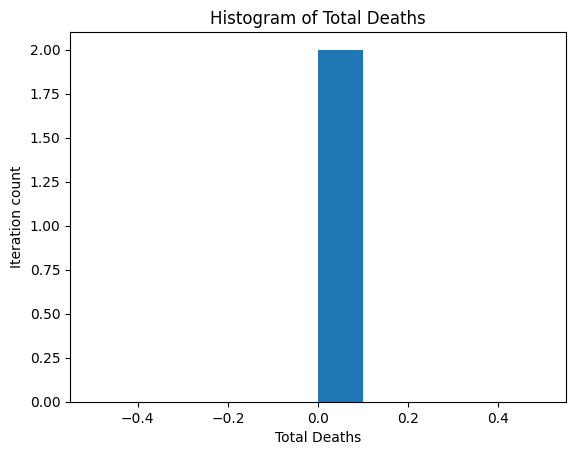

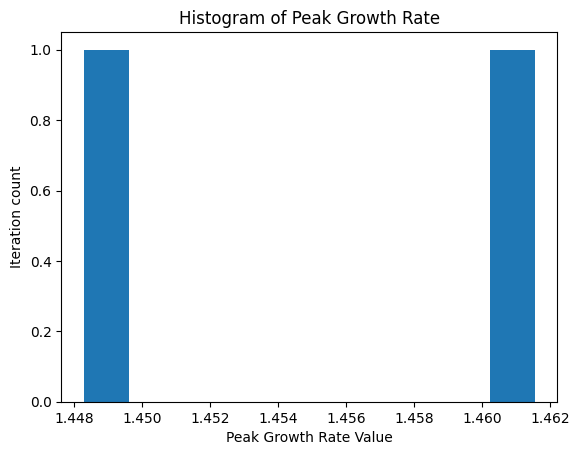

In [ ]:
#Initialize parameters hear in order to run the simulation
runSimulation(numPeople=20000, numLocations=300, maxRepLength=365, seedRun=False, vaccineDevelopmentIndicator=True, numRepetitions=30)
display(dfPandemicDuration)
#The mean_var_interval function is used to print out significant parameters
growthRateResult = mean_var_interval(dfPandemicDuration['Peak Growth Rate'])
pandemicDurationResult = mean_var_interval(dfPandemicDuration['Pandemic Duration'])
peakInfectedPopulation = mean_var_interval(dfPandemicDuration['Peak Infection'])
totalDeathPopulation = mean_var_interval(dfPandemicDuration['Total Deaths'])

print("The sample mean of the growth rate is: ", str(round(growthRateResult[0],2)))
print("The sample variance of the growth rate is: ", str(round(growthRateResult[4],2)))
print("The", growthRateResult[3], "confidence interval is", growthRateResult[2])

print("The sample mean of the Pandemic Duration is: ", str(round(pandemicDurationResult[0],2)))
print("The sample variance of the Pandemic Duration is: ", str(round(pandemicDurationResult[4],2)))
print("The", growthRateResult[3], "confidence interval is", pandemicDurationResult[2])

print("The sample mean of the Peak Infected Population is: ", str(round(peakInfectedPopulation[0],2)))
print("The sample variance of the Peak Infected Population is: ", str(round(peakInfectedPopulation[4],2)))
print("The", growthRateResult[3], "confidence interval is", peakInfectedPopulation[2])

print("The sample mean of the Total Deaths is: ", str(round(totalDeathPopulation[0],2)))
print("The sample variance of the Total Deaths is: ", str(round(totalDeathPopulation[4],2)))
print("The", growthRateResult[3], "confidence interval is", totalDeathPopulation[2])



In [ ]:
print("--- %s seconds ---" % (t.time() - start_time))

--- 37.86479330062866 seconds ---
